# Roberta-base training

In [1]:
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# Load the dataset
dataset = load_dataset('dair-ai/emotion')

# Convert to pandas dataframe
train_data = pd.DataFrame(dataset['train'])
val_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

print(train_data.head())
print(test_data.head())

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


In [3]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [4]:
train_data = train_data.drop_duplicates(subset='text')
train_data = train_data.reset_index(drop=True)

In [5]:
train_data.isna().values.any()

False

In [6]:
train_data['len'] = [len(text.split()) for text in train_data['text']]

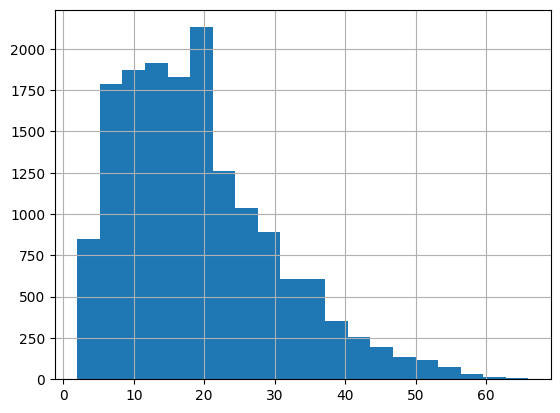

In [7]:
train_data['len'].hist(bins=20)
plt.show()

# Training

In [8]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import StepLR




import torch
import torch.nn as nn
import numpy as np


In [9]:
%%capture
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=6)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [10]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
import torch
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [12]:
train_dataset = CustomDataset(train_data['text'], train_data['label'])
val_dataset = CustomDataset(val_data['text'], val_data['label'])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [14]:
torch.cuda.empty_cache()

In [14]:
device = torch.device('cuda:0')
# device = torch.device('cpu')
model.to(device)

    
optimizer = torch.optim.AdamW([
    {'params': model.roberta.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])


epochs = 15
best_score = 0

Epoch:  14
124


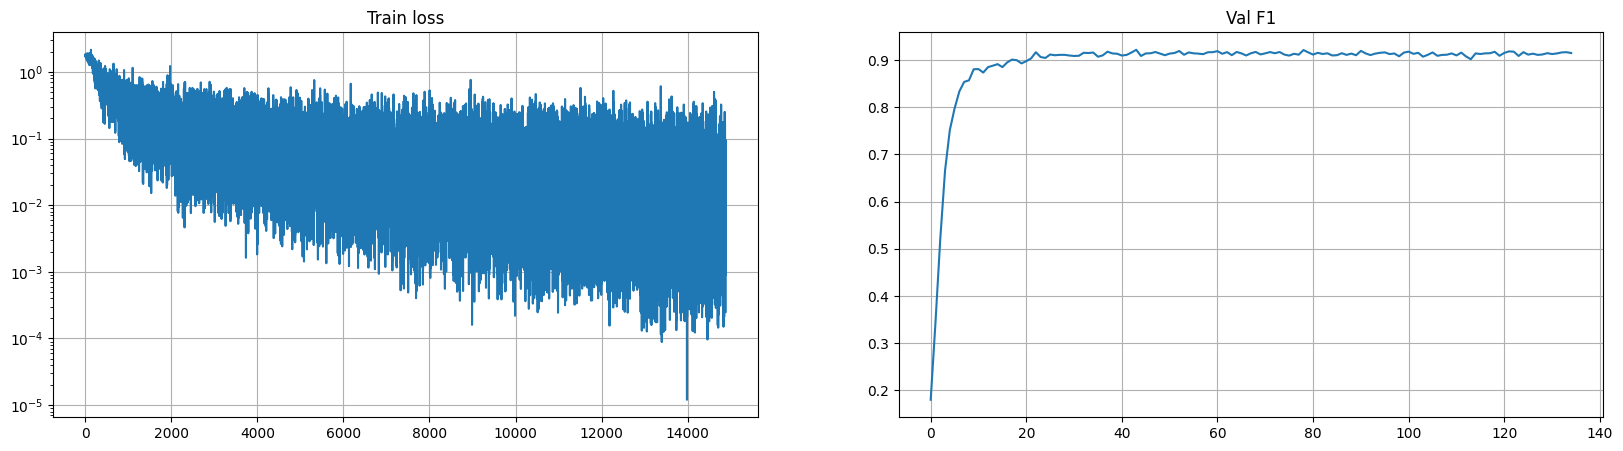

In [15]:
train_loss = []
val_metrics = []


for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        model.train()
        inputs = tokenizer(list(batch[0]), 
                           max_length=512, 
                           truncation=True,
                           padding='longest',
                           return_tensors='pt').to(device)
        logits = model(**inputs).logits
        loss = nn.CrossEntropyLoss()(logits, batch[1].to(device))
        loss.backward()
        if i % 5 == 0:
            optimizer.step()
            optimizer.zero_grad()
    #         scheduler.step()
        
        train_loss.append(loss.item())
        
        if i % 100 == 0 and i != 0:
            model.eval()
            labels = np.array([])
            preds = np.array([])
            for i, batch in enumerate(tqdm(val_dataloader)):
                inputs = tokenizer(list(batch[0]), 
                                   max_length=512, 
                                   truncation=True,
                                   padding='longest',
                                   return_tensors='pt').to(device)
                with torch.no_grad():
                    logits = model(**inputs).logits
                preds = np.append(preds,
                                torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
                labels = np.append(labels, batch[1].numpy())
                
            score = f1_score(preds, labels, average='macro')
            if score > best_score:
                model.save_pretrained('roberta-emotions')
                tokenizer.save_pretrained('roberta-emotions')
                best_score = score
                
            val_metrics.append(score)

            #print plots
            clear_output()
            print('Epoch: ', epoch)
            print(i)
            plt.figure(figsize=(20,5))
            plt.subplot(121)
            plt.semilogy(train_loss)
            plt.title('Train loss')
            plt.grid(True)
            plt.subplot(122)
            plt.plot(val_metrics)
            plt.title('Val F1')
            plt.grid(True)
            plt.show()
                
                
                    

                
        

# Inference

In [17]:
#load best model
model = RobertaForSequenceClassification.from_pretrained('roberta-emotions')
model.eval()
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Validation data

In [18]:
#inference
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(val_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       padding='longest',
                       return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    preds = np.append(preds,
                    torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
    labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/125 [00:00<?, ?it/s]

0.9219796776747552

In [19]:

names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.956364,0.985019,0.970480,534.000
joy,0.955966,0.958689,0.957326,702.000
love,0.859551,0.889535,0.874286,172.000
anger,0.956364,0.926056,0.940966,284.000
fear,0.924528,0.899083,0.911628,218.000
surprise,0.925926,0.833333,0.877193,90.000
accuracy,0.943000,0.943000,0.943000,0.943
macro avg,0.929783,0.915286,0.921980,2000.000
weighted avg,0.943058,0.943000,0.942786,2000.000


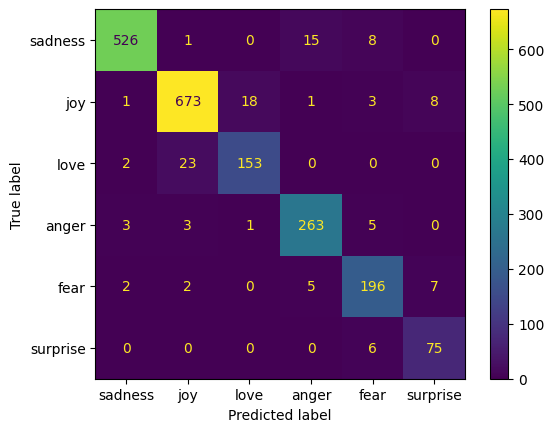

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(list(labels), preds )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
                              )
disp.plot()

plt.show()

## Test data

In [21]:
test_dataset = CustomDataset(test_data['text'], test_data['label'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
#inference
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(test_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       padding='longest',
                       return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    preds = np.append(preds,
                    torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
    labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/63 [00:00<?, ?it/s]

0.8790494668346943

In [23]:

names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.946644,0.980392,0.963222,561.000
joy,0.943885,0.943885,0.943885,695.000
love,0.798742,0.841060,0.819355,151.000
anger,0.941818,0.899306,0.920071,288.000
fear,0.879464,0.879464,0.879464,224.000
surprise,0.833333,0.679012,0.748299,81.000
accuracy,0.922000,0.922000,0.922000,0.922
macro avg,0.890648,0.870520,0.879049,2000.000
weighted avg,0.921710,0.922000,0.921342,2000.000
